In [1]:
import os

import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.gae.optimizer import optimizerAE, optimizerVAE,get_roc_score,accuracy
from gae.gae.model import GCNModelAE, GCNModelVAE
import gae.gae.model
from gae.gae.preprocessing import preprocess_graph, sparse_to_tuple, mask_test_edges,sparse_mx_to_torch_sparse_tensor
import gae.gae.preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd


from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


In [2]:
name='cycif_standardize_knn10_connectivity_seed3_10x4'
adj_path=os.path.join('/nfs','latdata','xinyi','cycif_data_for_gae','xamatrices','a','knn10_connectivity.npz')
features_path=os.path.join('/nfs','latdata','xinyi','cycif_data_for_gae','xamatrices','x','standardize.npz')
# Load data
adj_orig=sp.load_npz(adj_path)
features=sp.load_npz(features_path)
features=sparse_mx_to_torch_sparse_tensor(features)

hidden1=10 #Number of units in hidden layer 1
hidden2=4 #Number of units in hidden layer 2
dropout=0
model_str='gcn_vae'

num_nodes,num_features = features.shape
if model_str == 'gcn_ae':
    model = gae.gae.model.GCNModelAE(num_features, hidden1, hidden2, dropout)
elif model_str == 'gcn_vae':
    model  = gae.gae.model.GCNModelVAE(num_features, hidden1, hidden2, dropout)
elif model_str=='gcn_vae3':
    model  = gae.gae.model.GCNModelVAE3(num_features, hidden1, hidden2,hidden3, dropout)
model.load_state_dict(torch.load('gae/models/'+name+'.pt'))
## get embedding of full adjacency matrix
model.eval()
adj_norm_full = gae.gae.preprocessing.preprocess_graph(adj_orig)
adj_recon,mu,logvar = model(features, adj_norm_full)


In [20]:
cycif_celltype=pd.read_csv('/nfs/latdata/xinyi/cycif_data_for_gae/cycif_metadata.csv',header=0,index_col=0).loc[:,'real_label'].to_numpy()
labels_true=cycif_celltype

In [4]:
cycif_coord=pd.read_csv('/nfs/latdata/xinyi/cycif_data_for_gae/cycif_metadata.csv',header=0,index_col=0).loc[:,['centroid_x','centroid_y']].to_numpy()

In [22]:
np.unique(cycif_celltype)

array(['Bcell', 'Endothelial', 'Macrophage', 'Stromal', 'Tcell', 'Tumor',
       'Unknown'], dtype=object)

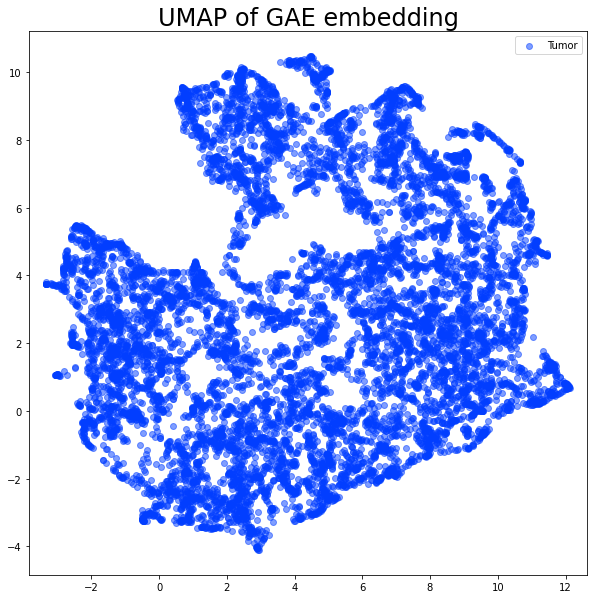

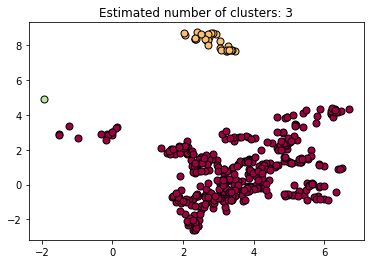

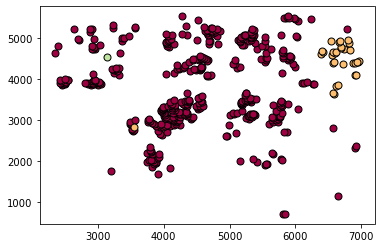

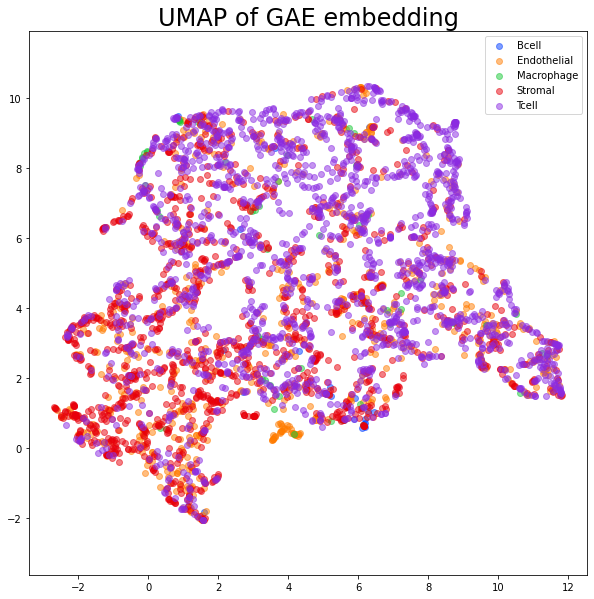

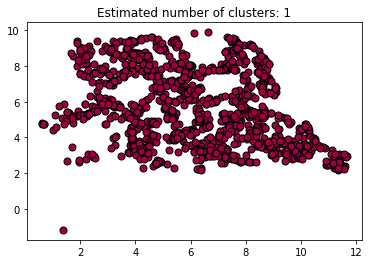

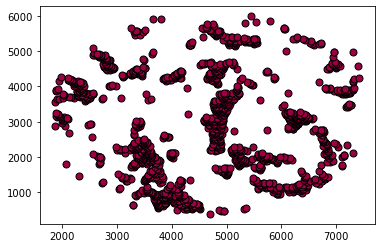

In [11]:
np.random.seed(3)
if not os.path.exists('gae/plots/'+name+'/tumor_subcluster'):
    os.makedirs('gae/plots/'+name+'/tumor_subcluster')
    
cellmask = {}
cellmask['tumor']=cycif_celltype=='Tumor'
cellmask['nontumor']=np.logical_and(cycif_celltype!='Tumor',cycif_celltype != 'Unknown')
    
colortest=sns.color_palette("bright")
colortest.extend(sns.color_palette("dark"))

# for ct in celltypes:
for ct in cellmask.keys():
    idx=cellmask[ct]
    emb_ct=mu.detach().numpy()
    emb_ct=emb_ct[idx,]
    
    reducer = umap.UMAP()
    umap_embedding_ct = reducer.fit_transform(emb_ct)
    
    if ct == 'tumor':
        subtypes=['Tumor']
    else:
        subtypes=['Bcell', 'Endothelial', 'Macrophage', 'Stromal', 'Tcell']
    fig, ax = plt.subplots()
    cidx=0
    for subct in subtypes:
        idx_sub=cycif_celltype==subct
        idx_sub=idx_sub[idx]
        ax.scatter(
            umap_embedding_ct[idx_sub, 0],
            umap_embedding_ct[idx_sub, 1],
            color=colortest[cidx],label=subct,alpha=0.5
            )
        cidx+=1

    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax.legend()
    plt.title('UMAP of GAE embedding', fontsize=24)
    plt.savefig('gae/plots/'+name+'/tumor_subcluster/seed3_umapCT_'+ct+'.jpg')
    plt.show()
    
    db = DBSCAN(eps=0.3, min_samples=50).fit(emb_ct)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = umap_embedding_ct[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=7)

    #     xy = umap_embedding[class_member_mask & ~core_samples_mask]
    #     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
    #              markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.savefig('gae/plots/'+name+'/tumor_subcluster/seed3_umapCT_'+ct+'_dbscan_eps03_min_samples50.jpg')
    plt.show()
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = cycif_coord[idx,]
        xy=xy[class_member_mask & core_samples_mask]
        plt.plot(xy[:,0], xy[:,1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=7)
    plt.savefig('gae/plots/'+name+'/tumor_subcluster/seed3_umapCT_'+ct+'_dbscan_location_eps03_min_samples50.jpg')
    plt.show()

Bcell


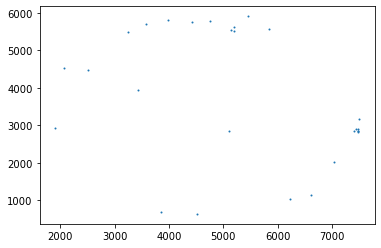

Endothelial


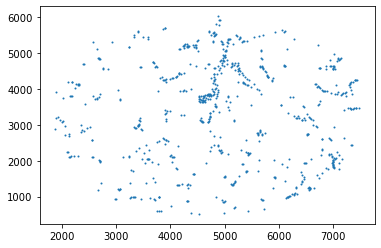

Macrophage


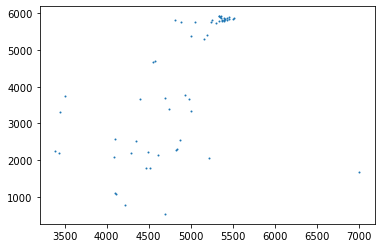

Stromal


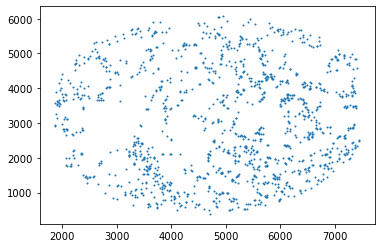

Tcell


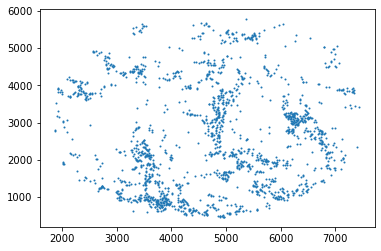

Tumor


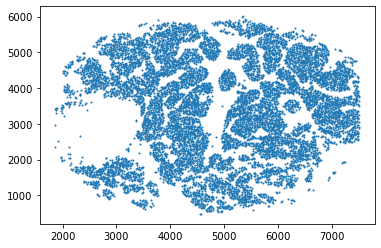

Unknown


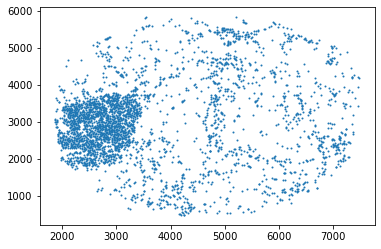

In [26]:
for k, col in zip(np.unique(cycif_celltype), [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(np.unique(cycif_celltype)))]):
        print(k)
        class_member_mask = (cycif_celltype == k)

        xy=cycif_coord[class_member_mask,:]
        plt.plot(xy[:,0], xy[:,1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor=None, markersize=1,label=k)
        plt.show()